In [70]:
import torch_geometric.transforms as T
import os.path as osp
from sklearn.manifold import TSNE
import torch
import umap

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random
from scipy.integrate import simps
from matplotlib import cm
from matplotlib.patches import Ellipse
import seaborn as sns
from scipy.spatial.distance import cdist
from numpy.linalg import LinAlgError
import re

from sklearn.preprocessing import StandardScaler

Read in data

In [71]:
window = 60 * 60

day_1_start = (8 * 60 + 30) * 60
day_1_end = (17 * 60 + 30) * 60
day_2_start = ((24 + 8) * 60 + 30) * 60
day_2_end = ((24 + 17) * 60 + 30) * 60

T1 = int((day_1_end - day_1_start) // window)
T2 = int((day_2_end - day_2_start) // window)
T = T1 + T2

print(f"Number of time windows: {T}")

# %%
fname = "ia-primary-school-proximity-attr.edges"
file = open(fname)

label_dict = {
    "1A": 0,
    "1B": 1,
    "2A": 2,
    "2B": 3,
    "3A": 4,
    "3B": 5,
    "4A": 6,
    "4B": 7,
    "5A": 8,
    "5B": 9,
    "Teachers": 10,
}
num_classes = 10

nodes = []
node_labels = []
edge_tuples = []

for line in file:
    node_i, node_j, time, id_i, id_j = line.strip("\n").split(",")

    if day_1_start <= int(time) < day_1_end:
        t = (int(time) - day_1_start) // window
    elif day_2_start <= int(time) < day_2_end:
        t = T1 + (int(time) - day_2_start) // window
    else:
        continue

    if node_i not in nodes:
        nodes.append(node_i)
        node_labels.append(label_dict[id_i])

    if node_j not in nodes:
        nodes.append(node_j)
        node_labels.append(label_dict[id_j])

    edge_tuples.append([t, node_i, node_j])

edge_tuples = np.unique(edge_tuples, axis=0)
nodes = np.array(nodes)

n = len(nodes)
print(f"Number of nodes: {n}")

node_dict = dict(zip(nodes[np.argsort(node_labels)], range(n)))
node_labels = np.sort(node_labels)

# %% [markdown]
# Create a list of adjacency matrices.

# %%
As = np.zeros((T, n, n))

for m in range(len(edge_tuples)):
    t, i, j = edge_tuples[m]
    As[int(t), node_dict[i], node_dict[j]] = 1
    As[int(t), node_dict[j], node_dict[i]] = 1

Number of time windows: 18
Number of nodes: 242


In [72]:
# Format the data to work with existing code
labels = node_labels

# just look at first (whatever is specified) timepoint
dense_adj = As[0]

Define functions for notebook

In [119]:
def compute_area_above_below_curve(x, y):
    area_above = 0.0
    area_below = 0.0
    
    for i in range(1, len(x)):
        x0, x1 = x[i - 1], x[i]
        y0, y1 = y[i - 1], y[i]
        line0, line1 = x0, x1  # Since line y = x
        
        if y1 == y0:  # Vertical segment
            if y0 > x0:
                area_above += (y0 - x0) * (x1 - x0)
            else:
                area_below += (x0 - y0) * (x1 - x0)
            continue
        
        # Find intersection with y = x
        if (y0 >= x0 and y1 >= x1) or (y0 <= x0 and y1 <= x1):
            if y0 >= x0 and y1 >= x1:
                area_above += 0.5 * (y0 + y1 - x0 - x1) * (x1 - x0)
            else:
                area_below += 0.5 * (x0 + x1 - y0 - y1) * (x1 - x0)
        else:
            x_intersect = x0 + (x0 - y0) * (x1 - x0) / (y1 - y0)
            if y0 < x0:
                area_below += 0.5 * (x0 - y0) * (x_intersect - x0)
                area_above += 0.5 * (y1 - x1) * (x1 - x_intersect)
            else:
                area_above += 0.5 * (y0 - x0) * (x_intersect - x0)
                area_below += 0.5 * (x1 - y1) * (x1 - x_intersect)
    
    return area_above, area_below


# def plot_ellipse(ax, mean, cov, color):
#     eigenvalues, eigenvectors = np.linalg.eigh(cov)
#     order = eigenvalues.argsort()[::-1]
#     eigenvalues = eigenvalues[order]
#     eigenvectors = eigenvectors[:, order]
#     angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
#     width, height = 2 * np.sqrt(eigenvalues[:2])
#     ellipse = Ellipse(mean, width, height, angle, edgecolor=color, facecolor='none', lw=2, label=f'Covariance Ellipse ({color})')
#     ax.add_patch(ellipse)


def plot_ellipse(ax, mean, cov, color, lw=2):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues[:2])
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor=color, facecolor='none', lw=lw, label=f'Covariance Ellipse ({color})')
    ax.add_patch(ellipse)



# TO AVOID SINGULAR MATRIX ERROR
def points_within_ellipse(points, mean, cov, regularization=1e-32):
    try:
        # Attempt to calculate the inverse of the covariance matrix
        inv_cov = np.linalg.inv(cov)
    except LinAlgError:
        # If the matrix is singular, regularize and retry
        cov += np.eye(cov.shape[0]) * regularization
        inv_cov = np.linalg.inv(cov)
    
    # Calculate the Mahalanobis distance from the mean
    diff = points - mean
    mahalanobis_distances = np.sum(diff @ inv_cov * diff, axis=1)
    
    # Points within the ellipse have a Mahalanobis distance <= 1
    return mahalanobis_distances <= 1


In [142]:
k = 4
d = 2

100%|██████████| 20/20 [00:00<00:00, 68.95it/s]


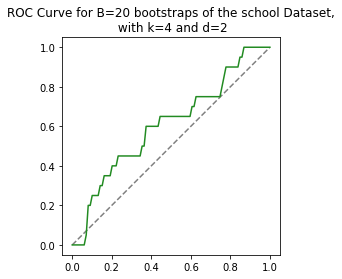

Total area (above and below y=x): 0.11567717785960821 for k=4


In [143]:
# obs_adj is the observed adjacency matrix
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

B = 20

p_vals = []
A_boots_list = []

for b in tqdm(range(B)):
    p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

# Provided code
p_hat_list = p_vals
roc = []
alphas = []

for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]

plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title(f"ROC Curve for B={B} bootstraps of the school Dataset,\n with k={k} and d={d}")
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

# Calculate the area between ROC and y=x line
x = np.linspace(0, 1, 100)
roc_interpolated = np.interp(x, alphas, roc)

# Compute areas
area_above, area_below = compute_area_above_below_curve(x, roc_interpolated)
total_area = area_above + area_below

print(f"Total area (above and below y=x): {total_area} for k={k}")

In [144]:
A_list = [dense_adj] + A_boots_list
len(A_list)

yhat = UASE(A_list, d=d, sparse_matrix=False)

In [145]:
yadf = pd.DataFrame(yhat)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = np.tile(node_labels, B + 1)


# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(B+1), len(labels))

# repeat range(len(node_labels)) B+1 times to give each node a unique number
yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)

Create ``similarity matrix $U$''  matrix from the obs and B=20 bootstraps to estimate `in_cov_friends_symm`

In [146]:
""""create this weird new adjacency matrix"""
in_cov_friends = np.zeros((n,n))

for i in range(n):
    # Filter data for node number and select the relevant dimensions
    node_number = i
    data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

    # Calculate the mean and covariance considering all d dimensions
    mean_d_dim = np.mean(data_d_dim, axis=0)
    cov_d_dim = np.cov(data_d_dim, rowvar=False)

    # Use the point corresponding to the specific node_number in matrix 0 as the center
    point = data_d_dim[0]
    obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

    # Plotting only the first two dimensions
    data_2d = data_d_dim[:, 0:2]
    obs_points_2d = obs_points[:, 0:2]

    # Filter points within the ellipse
    inside_ellipse = points_within_ellipse(obs_points_2d, point[:2], cov_d_dim[:2, :2])

    # Extract node numbers for points inside the ellipse
    node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

    # set in_cov_friends[i, node_numbers_inside_ellipse] = 1
    in_cov_friends[i, node_numbers_inside_ellipse] = 1

    # symmetrize the matrix in_cov_friends - 
# minimum means both must be 1
# maximum means at least one must be 1
in_cov_friends_symm = np.minimum(in_cov_friends, in_cov_friends.T)
# sns.heatmap(in_cov_friends_symm, square=True)

<Axes: >

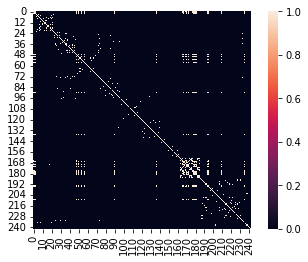

In [147]:
sns.heatmap(in_cov_friends_symm, square=True)

Plot the $d=2$ embedding of $A^{(obs)}$ from the UASE of $A^{(obs)}$ and the $B=20$ bootstraps

with the lines from the $U$ matrix added

In [148]:
import plotly.express as px

# Example plot
fig = px.scatter(yadf, 
                 x='Dimension_1', 
                 y='Dimension_2', 
                 color='tau', 
                 animation_frame='Matrix')

fig.show()

/tmp/ipykernel_20976/1647310400.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



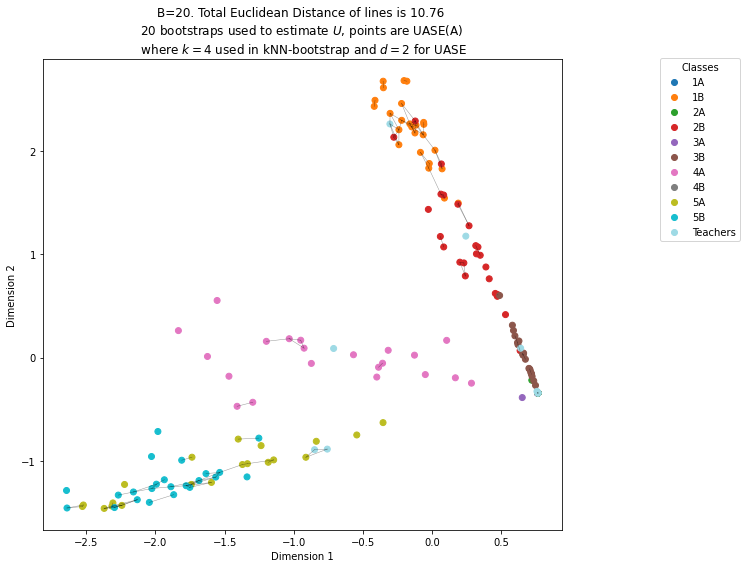

In [149]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(8,8))

Aobs_yadf = yadf[yadf["Matrix"] == 0]

# Standardize the data in the Dimension_1 and Dimension_2 columns - so Dimension_1 and Dimension_2 have mean 0 and standard deviation 1
scaler = StandardScaler()
# Fit the scaler on the Dimension columns and transform them
Aobs_yadf[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(Aobs_yadf[["Dimension_1", "Dimension_2"]])

# Plot the scatter plot
scatter = ax.scatter(Aobs_yadf["Dimension_1"], Aobs_yadf["Dimension_2"], c=Aobs_yadf["tau"], cmap='tab20')
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

# Ensure matrix dimensions match, and avoid accessing out-of-bounds indices
num_nodes = len(Aobs_yadf)
if in_cov_friends_symm.shape != (num_nodes, num_nodes):
    raise ValueError(f"Expected in_cov_friends_symm to have dimensions ({num_nodes}, {num_nodes}), but got {in_cov_friends_symm.shape}.")

# Draw lines between connected nodes based on the adjacency matrix
# And calculate the total euclidean distance that the lines connecting the nodes in the d=2 space of A from UASE
total_distance = 0
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
            ax.plot([Aobs_yadf["Dimension_1"].iloc[i], Aobs_yadf["Dimension_1"].iloc[j]], 
                    [Aobs_yadf["Dimension_2"].iloc[i], Aobs_yadf["Dimension_2"].iloc[j]], 
                    'k-', lw=0.5, alpha=0.4)  # Draw a line between them
            # Add this euclidean distance to the total_distance
            total_distance += np.linalg.norm(Aobs_yadf[["Dimension_1", "Dimension_2"]].iloc[i] - 
                                             Aobs_yadf[["Dimension_1", "Dimension_2"]].iloc[j])

# Round the total distance for clarity
total_distance = round(total_distance, 2)

# Set the title
ax.set_title(f"B={B}. Total Euclidean Distance of lines is {total_distance} \n{B} bootstraps used to estimate $U$, points are UASE(A) \n where $k={k}$ used in kNN-bootstrap and $d={d}$ for UASE")  

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  # Inverse mapping
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv.get(numeric_label, "Unknown"))

# Add the legend with the mapped labels
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(1.3, 0.9))

# Adjust layout to make room for titles and labels
plt.tight_layout()

plt.savefig("school_A0_B20_plot_UASE(A)_d2_sd1mean0.png", bbox_inches='tight', facecolor='white')

# Show the combined plot
plt.show()


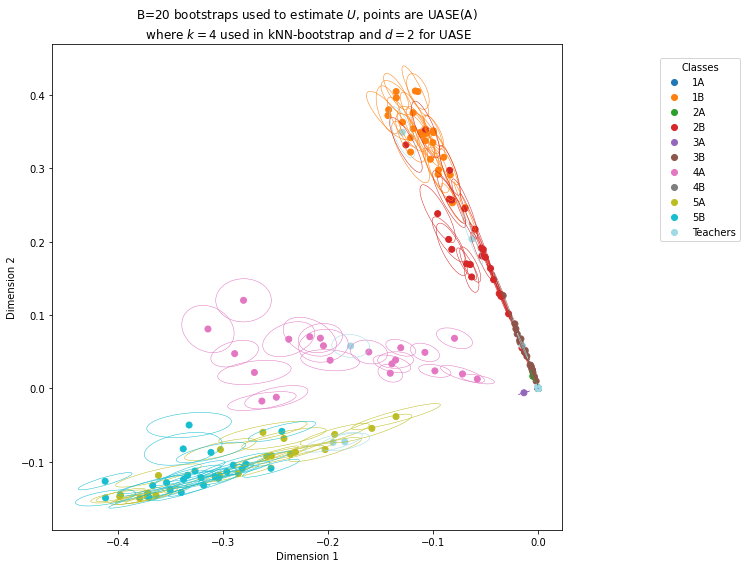

In [150]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 8))

Aobs_yadf = yadf[yadf["Matrix"] == 0]

# Plot the scatter plot
scatter = ax.scatter(Aobs_yadf["Dimension_1"], Aobs_yadf["Dimension_2"], c=Aobs_yadf["tau"], cmap='tab20')
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

# Retrieve the colors assigned by the scatter plot
scatter_colors = scatter.to_rgba(Aobs_yadf["tau"])

for i in range(len(Aobs_yadf)):
    # Filter data for node number and select the relevant dimensions
    node_number = i
    data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

    # Calculate the covariance considering all d dimensions
    cov_d_dim = np.cov(data_d_dim, rowvar=False)

    # Use the color of the scatter point for the ellipse
    color = scatter_colors[i]

    # plot the covariance ellipse with the same color as the point
    plot_ellipse(ax, data_d_dim[0, :2], cov_d_dim[:2, :2], color=color, lw=0.5)

# Set the title
ax.set_title(f"B={B} bootstraps used to estimate $U$, points are UASE(A) \n where $k={k}$ used in kNN-bootstrap and $d={d}$ for UASE")  

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  # Inverse mapping
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv.get(numeric_label, "Unknown"))

# Add the legend with the mapped labels
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(1.3, 0.9))

# Adjust layout to make room for titles and labels
plt.tight_layout()

plt.savefig("school_A0_B20_plot_UASE(A)_d2_varBubbles.png", bbox_inches='tight', facecolor='white')

# Show the combined plot
plt.show()

just plot class 4A 

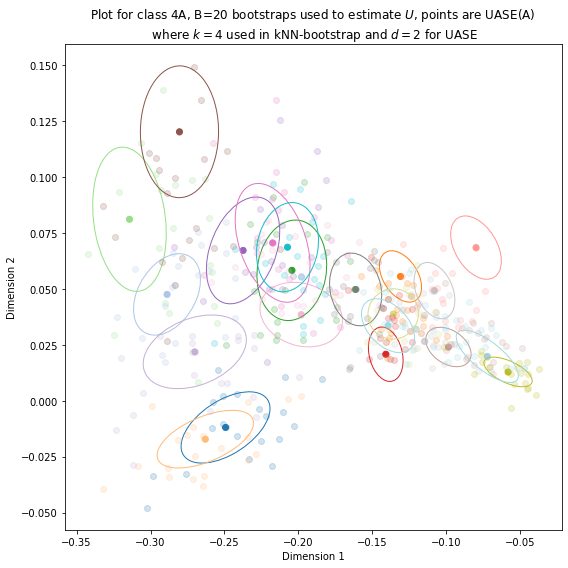

In [154]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 8))

Aobs_yadf = yadf[yadf["Matrix"] == 0]

Aobs_yadf_4A = Aobs_yadf[Aobs_yadf["tau"] == 6]

# Plot the scatter plot
scatter = ax.scatter(Aobs_yadf_4A["Dimension_1"], Aobs_yadf_4A["Dimension_2"], c=Aobs_yadf_4A["NodeNumber"], cmap='tab20')
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

# Retrieve the colors assigned by the scatter plot
scatter_colors = scatter.to_rgba(Aobs_yadf_4A["NodeNumber"])

for i in range(len(Aobs_yadf_4A)):
    # Filter data for node number and select the relevant dimensions
    node_number = i + np.min(Aobs_yadf_4A['NodeNumber'])
    data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

    # plot the bootstrap points
    ax.scatter(data_d_dim[:, 0], data_d_dim[:, 1], color=scatter_colors[i], alpha=0.2)

    # Calculate the covariance considering all d dimensions
    cov_d_dim = np.cov(data_d_dim, rowvar=False)

    # Use the color of the scatter point for the ellipse
    color = scatter_colors[i]

    # plot the covariance ellipse with the same color as the point
    plot_ellipse(ax, data_d_dim[0, :2], cov_d_dim[:2, :2], color=color, lw=1)

# Set the title
ax.set_title(f"Plot for class 4A, B={B} bootstraps used to estimate $U$, points are UASE(A) \n where $k={k}$ used in kNN-bootstrap and $d={d}$ for UASE")  

# Adjust layout to make room for titles and labels
plt.tight_layout()

plt.savefig("school_A0_B20_plot_UASE(A)_d2_class4A_varBubbles.png", bbox_inches='tight', facecolor='white')

# Show the combined plot
plt.show()

#### find out about points close to the origin

In [160]:
Aobs_yadf_originPoints = Aobs_yadf[(abs(Aobs_yadf['Dimension_1'])< 0.05 ) & (abs(Aobs_yadf['Dimension_2'])< 0.05)]

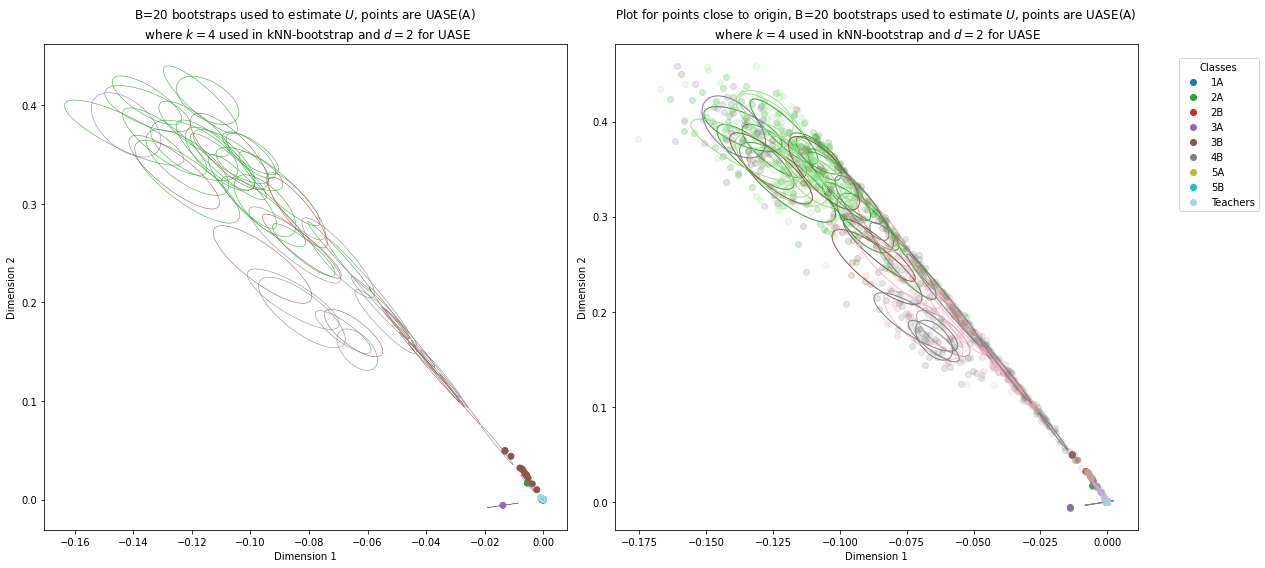

In [162]:
# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# ---------------------------- First Plot ----------------------------
Aobs_yadf = yadf[yadf["Matrix"] == 0]

# Plot the scatter plot in the first subplot (axes[0])
scatter1 = axes[0].scatter(Aobs_yadf_originPoints["Dimension_1"], Aobs_yadf_originPoints["Dimension_2"], c=Aobs_yadf_originPoints["tau"], cmap='tab20')
axes[0].set_xlabel("Dimension 1")
axes[0].set_ylabel("Dimension 2")

# Retrieve the colors assigned by the scatter plot
scatter_colors = scatter1.to_rgba(Aobs_yadf_originPoints["tau"])

for i in range(len(Aobs_yadf_originPoints)):
    # Filter data for node number and select the relevant dimensions
    node_number = i
    data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

    # Calculate the covariance considering all d dimensions
    cov_d_dim = np.cov(data_d_dim, rowvar=False)

    # Use the color of the scatter point for the ellipse
    color = scatter_colors[i]

    # plot the covariance ellipse with the same color as the point
    plot_ellipse(axes[0], data_d_dim[0, :2], cov_d_dim[:2, :2], color=color, lw=0.5)

# Set the title for the first plot
axes[0].set_title(f"B={B} bootstraps used to estimate $U$, points are UASE(A) \n where $k={k}$ used in kNN-bootstrap and $d={d}$ for UASE")  

# Add legend for the first plot
handles1, labels_legend1 = scatter1.legend_elements()
mapped_labels1 = []
for label in labels_legend1:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels1.append(label_dict_inv.get(numeric_label, "Unknown"))
fig.legend(handles1, mapped_labels1, title="Classes", loc="upper right", bbox_to_anchor=(1.1, 0.9))

# ---------------------------- Second Plot ----------------------------
# Plot the scatter plot in the second subplot (axes[1])
scatter2 = axes[1].scatter(Aobs_yadf_originPoints["Dimension_1"], Aobs_yadf_originPoints["Dimension_2"], c=Aobs_yadf_originPoints["NodeNumber"], cmap='tab20')
axes[1].set_xlabel("Dimension 1")
axes[1].set_ylabel("Dimension 2")

# Retrieve the colors assigned by the scatter plot
scatter_colors2 = scatter2.to_rgba(Aobs_yadf_originPoints["NodeNumber"])

for i in range(len(Aobs_yadf_originPoints)):
    # Filter data for node number and select the relevant dimensions
    node_number = i + np.min(Aobs_yadf_originPoints['NodeNumber'])
    data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

    # plot the bootstrap points
    axes[1].scatter(data_d_dim[:, 0], data_d_dim[:, 1], color=scatter_colors2[i], alpha=0.2)

    # Calculate the covariance considering all d dimensions
    cov_d_dim = np.cov(data_d_dim, rowvar=False)
    mean_d_dim = np.mean(data_d_dim, axis=0)

    # Use the color of the scatter point for the ellipse
    color = scatter_colors2[i]

    # plot the covariance ellipse with the same color as the point
    plot_ellipse(axes[1], mean_d_dim[:2], cov_d_dim[:2, :2], color=color, lw=1)

# Set the title for the second plot
axes[1].set_title(f"Plot for points close to origin, B={B} bootstraps used to estimate $U$, points are UASE(A) \n where $k={k}$ used in kNN-bootstrap and $d={d}$ for UASE")

# Adjust layout to make room for titles and labels
plt.tight_layout()

plt.savefig("school_A0_B20_plot_UASE(A)_d2_varBubbles_originPoints.png", bbox_inches='tight', facecolor='white')

# Show the combined plot with both subplots
plt.show()


In [175]:
Aobs_yadf_originPoints.value_counts('tau')

# make this a dataframe and match the tau to the classname
df = pd.DataFrame(Aobs_yadf_originPoints.value_counts('tau')).reset_index()
df['Class'] = df['tau'].map(label_dict_inv)
df = df.rename(columns={0: 'Count'})

# add a column using Aobs_yadf to see how many students are in each class
df2 = Aobs_yadf.value_counts('tau')
df2 = pd.DataFrame(df2).reset_index()

df = df.merge(df2, left_on='tau', right_on='tau', how='left')
df.rename(columns={'count_y': 'TotalNumberStudents', 'count_x':'studentsNearOrigin'}, inplace=True)

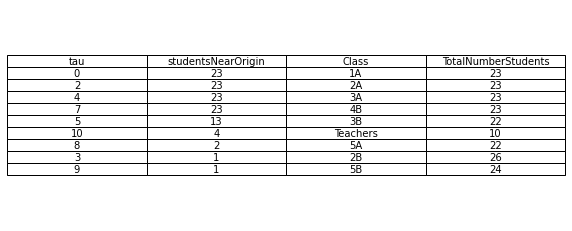

In [178]:
# print df to an image of the table
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')
ax.table(cellText=df.values, colLabels=df.columns, cellLoc = 'center', loc='center')
plt.savefig("school_A0_B20_plot_UASE(A)_d2_varBubbles_originPoints_table.png", bbox_inches='tight', facecolor='white')
plt.show()

In [194]:
# for each value in Aobs_yadf_originPoints, look in in_cov_friends_symm and find the row sum
# this will give the number of friends each student has
# add this to the dataframe

originPt_indexes = Aobs_yadf_originPoints['NodeNumber'].tolist()

in_cov_friends_symm_origin = in_cov_friends_symm[originPt_indexes, :]
in_cov_friends_symm_origin_friendCount = in_cov_friends_symm_origin.sum(axis=1).astype(int)
in_cov_friends_symm_origin_friendCount = list(in_cov_friends_symm_origin_friendCount)
len(in_cov_friends_symm_origin_friendCount)

Aobs_yadf_originPoints['NumFriends'] = in_cov_friends_symm_origin_friendCount

In [ ]:
# Drop the "Matrix" column from the DataFrame
Aobs_yadf_originPoints_cleaned = Aobs_yadf_originPoints.drop(columns=["Matrix"])

fig, ax = plt.subplots(figsize=(15, 30))
ax.axis('off')  # Hide the axis
ax.table(cellText=Aobs_yadf_originPoints_cleaned.values, colLabels=Aobs_yadf_originPoints_cleaned.columns, cellLoc='center', loc='center')

plt.savefig("school_A0_B20_plot_UASE(A)_d2_originPoints_numFriends_table.png", bbox_inches='tight', facecolor='white')
# plt.show()